# Cross-Validation

- Do **k-fold cross-validation** with independent test set
- Use scikit-learn for **hyperparameter optimization**

In [ ]:
%%capture

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Wrangle Data

## Import Data

In [ ]:
import pandas as pd

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')


Let's make a `wrangle` function

In [ ]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)

  # Drop repeated columns
  cols = ['extraction_type_group', 'quantity']
  X.drop(columns=cols, inplace=True)

  return X

In [ ]:
train = wrangle(train)

# Split Data

## Split TV from FM

In [ ]:
target = 'status_group'
y_train = train[target]
X_train = train.drop(columns=target)

# Training-Validation Split

- Since we're doing k-fold CV, there's no need for a validation set.

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Sanity check
# assert len(X_train) + len(X_val) == len(X)

# Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5430899510092763


![]()

# Build Model(s)

- Using k-fold CV

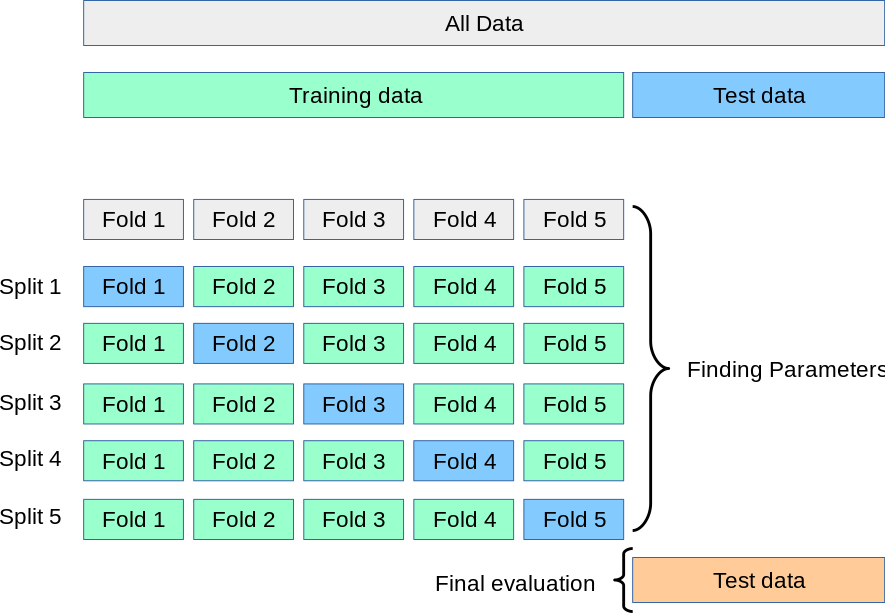

In [ ]:
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

Build Model

In [ ]:
tree_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42) # <-- no need to scale
)

Cross Validation

In [ ]:
scores = cross_val_score(tree_model, X_train, y_train, cv=10)

In [ ]:
scores

array([0.75555556, 0.75909091, 0.75723906, 0.75387205, 0.76666667,
       0.753367  , 0.75909091, 0.75420875, 0.75185185, 0.75568277])

In [ ]:
print('Mean CV accuracy', scores.mean())
print('STD accuracy', scores.std())

Mean CV accuracy 0.7566625535820686
STD accuracy 0.004027473020686456


 Another Option: Some models in sklearn come with k-fold cv built in.

In [ ]:
log_model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegressionCV(cv=5, n_jobs=-1)
)

log_model.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
log_model.named_steps['logisticregressioncv'].C_

array([0.00077426, 0.00077426, 0.00077426])

# Tune Model

- What are important hyperparameters for `RandomForestClassifier`?
  - `n_estimators`: 50 - 250
  - `max_sample`: 0.2 - 0.7  
  - `max_depth`: 5 - 30

In [ ]:
RandomForestClassifier?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

params = {
    'randomforestclassifier__n_estimators': range(50,251,50),
    'randomforestclassifier__max_depth': range(5,31,5),
    'randomforestclassifier__max_samples': np.arange(0.2, 0.7, 0.2)
}

model = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=3
)

In [ ]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
y_pred = model.predict(X_train)